In [1]:
import sys, os
sys.path.append('/home/daniel/Documents/Uni/MT/poi-prediction')
from src.dataset.dataset import GruberDataset, ImplantsDataset, JointDataset
import time
from utils.misc import np_to_bids_nii
from utils.dataloading_utils import compute_surface
from tqdm import tqdm

from BIDS import POI, NII
from BIDS.POI_plotter import visualize_pois
import torch
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

gruber_master_df = pd.read_csv('/home/daniel/Data/Gruber/cutouts_scale-1-1-1/master_df.csv')
ds = GruberDataset(
    master_df = gruber_master_df,
    input_shape = (152,152,152),
    include_com = False,
    require_heatmap = False,
    flip_prob = 0
)

In [19]:
def fit_plane_to_points(X):
    n_points = X.shape[0]
    X = torch.cat([X, torch.ones(n_points, 1)], dim=1)  # Augment with ones for D coefficient
    U, S, V = torch.linalg.svd(X, full_matrices=False)
    plane_coefficients = V[-1, :]
    A, B, C, D = plane_coefficients

    # Calculate projection error as the sum of squared distances of points to the plane
    n = torch.tensor([A, B, C])
    distances = (torch.matmul(X[:, :-1], n) + D) / torch.linalg.norm(n)
    projection_error = torch.sum(distances ** 2)

    # Step 3: Project points onto the plane
    n_normalized = n / torch.linalg.norm(n)
    projection_vectors = distances.view(-1, 1) * n_normalized
    points_projected = X[:, :-1] - projection_vectors  # Use original points, not augmented

    return plane_coefficients, distances, points_projected

In [20]:
central_poi_ids = [81,101,103,102,104,125,127,134,136]

In [ ]:
dd = ds[0]
poi_mask = np.isin(dd['target_indices'], central_poi_ids)
central_pois = dd['target'][poi_mask]

In [46]:
avg_projection_distances = torch.tensor([])
avg_angles = torch.tensor([])
for dd in ds:
    poi_mask = np.isin(dd['target_indices'], central_poi_ids)
    central_pois = dd['target'][poi_mask]
    coeffs, d, _ = fit_plane_to_points(central_pois.clone().detach())
    avg_projection_distances = torch.cat([avg_projection_distances, d])
    normal = coeffs[:3]
    normal = normal / torch.linalg.norm(normal)
    n_ref = torch.tensor([1,0,0]).float()
    abs_cos_theta = torch.abs(torch.dot(normal, n_ref))
    angle = torch.acos(abs_cos_theta)
    angle = angle * 180 / np.pi
    avg_angles = torch.cat([avg_angles, angle.view(1)])

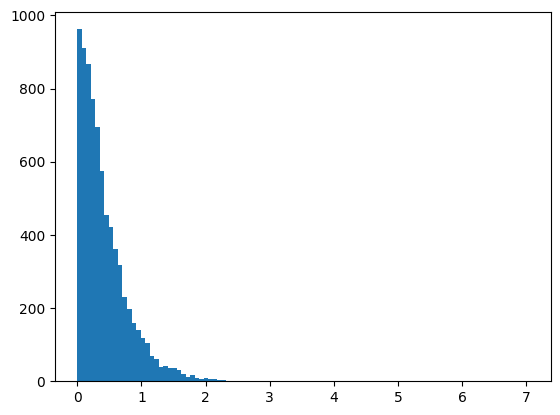

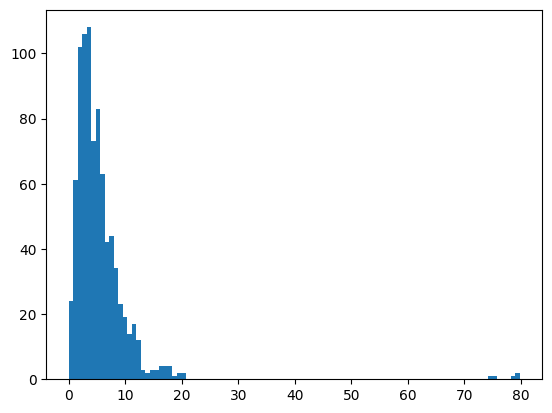

In [47]:
#Plot the average projection distance for each sample
avg_projection_distances = np.array(avg_projection_distances)
avg_projection_distances = np.abs(avg_projection_distances)

plt.hist(avg_projection_distances, bins=100)
plt.show()

#Plot the average angle between the normal of the plane and the reference normal
avg_angles = np.array(avg_angles)
plt.hist(avg_angles, bins=100)
plt.show()

In [56]:
#Calculate mean, 5, 25, 50, 75, 95 percentiles for the projection distances
percentiles = np.percentile(avg_projection_distances, [5,25,50,75,95])
print(percentiles)

[0.02854537 0.1452278  0.31657554 0.58666556 1.17289445]


In [32]:
normal_vec = torch.tensor([p_coeffs[0], p_coeffs[1], p_coeffs[2]])
normal_vec = normal_vec / torch.linalg.norm(normal_vec)
normal_vec

tensor([0.9977, 0.0492, 0.0459])